In [1]:
import os
from multiprocessing import cpu_count
import yaml

import h5py
import numexpr
import numpy as np
import pandas as pd
import requests
import scipy as sci
import scipy.signal as signal
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scripts.general import attribution, data

numexpr.set_num_threads(cpu_count() - 4)
# pd.set_option('compute.use_numba', True)


def left_align(df: pd.DataFrame):
    """https://stackoverflow.com/a/63869860"""
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

AAindex calculations and correlation filtering was performed in the `physical_profiles.Rmd` notebook.

Index values for all proteins were saved to `../data/protein_features/uncorr_aaindex_profiles.h5`

**Note** Corr performed with unfiltered profiles, since small attention values might be relevant in relation to AAindex, and unclear what a baseline of noise might be (plus, it should not correlate).

In [2]:
aaindex_profiles_fname = '../../data/protein_features/uncorr_aaindex_profiles.h5'

with h5py.File(aaindex_profiles_fname, 'r') as store:
    probe_id = list(store.keys())[0]
    aa_indices = list(store[probe_id].keys())

print(aa_indices)

['BUNA790103', 'FINA910104', 'GEOR030103', 'GEOR030104', 'LEVM760103', 'MITS020101', 'NADH010107', 'NAKH920107', 'PALJ810107', 'QIAN880138', 'RICJ880104', 'RICJ880117', 'ROBB760107', 'TANS770102', 'TANS770108', 'VASM830101', 'WERD780103', 'WOEC730101']


In [3]:
request_aa = requests.get('https://www.genome.jp/aaindex/AAindex/list_of_indices')

aaindex_names = {}

for entry in request_aa.text.splitlines()[5:]:
    idx_name, descr = entry.split(' ', maxsplit=1)
    aaindex_names[idx_name] = descr

In [4]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_and_abundances = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'seq', 'Median_molecules_per_cell']
]
seq_and_abundances = seq_and_abundances.assign(length = seq_and_abundances['seq'].str.len())
seq_and_abundances = (
    seq_and_abundances
    .sort_values('swissprot_ac')
    .assign(prot_idx = np.arange(seq_and_abundances.shape[0]))
)

In [5]:
print('N. seq: ', seq_and_abundances.shape[0])

N. seq:  4750


In [6]:
print('Bonferroni-corrected p-values =', 0.05 / seq_and_abundances.shape[0])

Bonferroni-corrected p-values = 1.0526315789473684e-05


In [7]:
exp_dir = '.'

def get_aaindex_for_protein(protein_id: str, aaindex: str) -> np.array:
    with h5py.File(aaindex_profiles_fname, 'r') as store:
         index_values = np.array(store[protein_id][aaindex]['ELT1'])
    return index_values


def calc_profile_attention_corr(protein_id: str, aaindex: str) -> float:
    """
    Return highest absolute correlation between any of the proteins attention profiles
    and the protein's AAindex values
    """
    index_values = get_aaindex_for_protein(protein_id, aaindex)
    
    # Multiple profiles for a sequence
    attention_profiles, _ = attribution.load_profiles(protein_id, exp_dir)
    
    # Calc corr between aaindex and all profiles
    attention_corr = np.apply_along_axis(
        lambda profile: stats.pearsonr(profile, index_values),
        axis = 1,
        arr = attention_profiles
    )
    
    # Keep only significant corr (low p-value) with Bonferroni correction
    pvalue_threshold = 0.05 / seq_and_abundances.shape[0]
    signif_att_corr = attention_corr[attention_corr[:, 1] < pvalue_threshold]
    signif_att_corr = signif_att_corr[:, 0]

    # Return max absolute value
    if signif_att_corr.shape[0] > 0:
        
        # HACK Appending to a global, but I can't be bothered
        argmax_pval = np.argmax(np.abs(signif_att_corr.ravel()))
        pvals.append(
            (aaindex, attention_corr[attention_corr[:, 1] < pvalue_threshold][argmax_pval, 1])
        )
        
        return max(signif_att_corr.min(), signif_att_corr.max(), key=abs)
    else:
        return None

# calc_profile_attention_corr('A2P2R3', 'ZIMJ680104')   # TEST

In [8]:
tqdm.pandas(desc="corr calc")

pvals = []

for aaindex in tqdm(aa_indices, desc="AA indices"):
    seq_and_abundances[aaindex] = seq_and_abundances['swissprot_ac'].apply(
            lambda prot_id: calc_profile_attention_corr(prot_id, aaindex)
        )
    
pvals = pd.DataFrame.from_records(pvals, columns = ['AAindex', 'p-value'])

AA indices: 100%|██████████| 18/18 [09:14<00:00, 30.81s/it]


In [9]:
attention_correlations = seq_and_abundances

In [10]:
attention_correlations = attention_correlations.drop(
    columns = ['seq', 'length', 'Median_molecules_per_cell', 'prot_idx']
)
attention_correlations = pd.melt(
    attention_correlations,
    id_vars='swissprot_ac',
    value_vars=attention_correlations.drop(columns='swissprot_ac').columns.values,
    var_name = 'AAindex'
)
attention_correlations = attention_correlations.assign(
    desc = attention_correlations['AAindex'].apply(lambda aai: aaindex_names[aai])
)

### Plot only higher correlations

In [11]:
CORR_THRESHOLD = 0.3

mean_att_cor = attention_correlations.groupby('AAindex').apply(lambda grp_df: grp_df['value'].abs().mean())
mean_att_cor = mean_att_cor.rename('value').reset_index()
hi_att_corr_aa_indices = mean_att_cor.query(f'value > {CORR_THRESHOLD}')['AAindex'].values
hi_corr_vals = attention_correlations[attention_correlations['AAindex'].isin(hi_att_corr_aa_indices)]

GEOR030103 : Linker propensity from 2-linker dataset 
MITS020101 : Amphiphilicity index 
NAKH920107 : AA composition of EXT of multi-spanning proteins 
RICJ880104 : Relative preference value at N1 
RICJ880117 : Relative preference value at C" 
TANS770102 : Normalized frequency of isolated helix 
TANS770108 : Normalized frequency of zeta R 
VASM830101 : Relative population of conformational state A 
WERD780103 : Free energy change of alpha
WOEC730101 : Polar requirement 


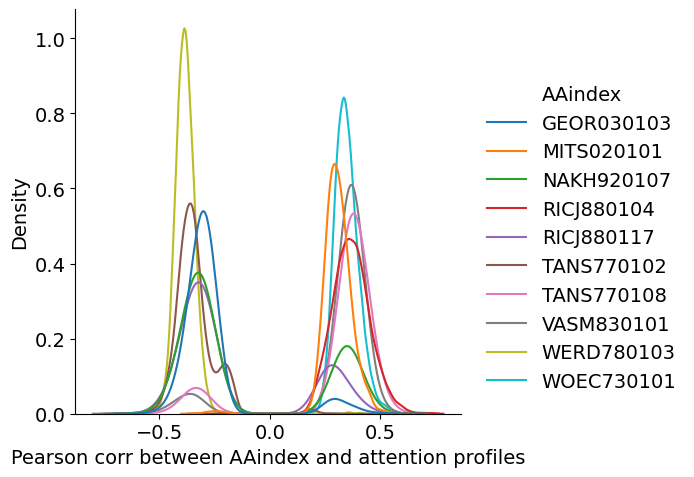

In [12]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14

splot = sns.displot(hi_corr_vals, 
                    x = 'value', hue='AAindex', kind = 'kde',
                    palette = 'tab10')
plt.xlabel('Pearson corr between AAindex and attention profiles')

for vals in hi_corr_vals[['AAindex', 'desc']].drop_duplicates().values:
    print(' : '.join(vals).split('(')[0])

# splot.savefig('aaindex_corr.pdf', dpi=100)

In [13]:
from collections import defaultdict

id_type_mapping = {
    'WERD780103': 'backbone conformation propensity',
    'TANS770108': 'backbone conformation propensity',
    'VASM830101': 'backbone conformation propensity',
    'TANS770102': 'backbone conformation propensity',
    'GEOR030103': 'domain linker propensity',
    'RICJ880104': 'preference for position at α-helix cap',
    'RICJ880117': 'preference for position at α-helix cap',
    'WOEC730101': 'polarity',
    'MITS020101': 'polarity',
    'NAKH920107': 'extracellular AA%',
}


palette = sns.color_palette('tab10')

aaidx_colors = {
    'backbone conformation propensity':       sns.color_palette(palette)[0],
    'polarity':                               sns.color_palette(palette)[1],
    'domain linker propensity':               '#555555',
    'preference for position at α-helix cap': sns.color_palette(palette)[3],
    'extracellular AA%':                      sns.color_palette(palette)[4]
}

property_type = defaultdict(lambda: 'other')
for k, v in id_type_mapping.items():
    property_type[k] = v

plot_type_names = list(map(lambda aaidx: property_type[aaidx], hi_corr_vals['AAindex'].unique()))
plot_type_colors = list(map(lambda aaidx_type: aaidx_colors[aaidx_type], plot_type_names))

In [14]:
corr_index_ranking = pd.merge(
    (hi_corr_vals.groupby('AAindex')
         .apply(lambda grp_df: grp_df['value'].abs().mean())
         .rename('abs_mean').reset_index()
         .sort_values('abs_mean', ascending=False)
    ),
    hi_corr_vals[['AAindex', 'desc']].drop_duplicates(),
    on='AAindex'
)

corr_index_ranking = corr_index_ranking.assign(
    index_type = corr_index_ranking['AAindex'].map(id_type_mapping.get)
)

corr_index_ranking

,AAindex,abs_mean,desc,index_type
0,WERD780103,0.383221,Free energy change of alpha(Ri) to alpha(Rh) (...,backbone conformation propensity
1,TANS770108,0.378532,Normalized frequency of zeta R (Tanaka-Scherag...,backbone conformation propensity
2,VASM830101,0.369834,Relative population of conformational state A ...,backbone conformation propensity
3,RICJ880104,0.368836,Relative preference value at N1 (Richardson-Ri...,preference for position at α-helix cap
4,WOEC730101,0.348673,"Polar requirement (Woese, 1973)",polarity
5,TANS770102,0.341910,Normalized frequency of isolated helix (Tanaka...,backbone conformation propensity
6,NAKH920107,0.336049,AA composition of EXT of multi-spanning protei...,extracellular AA%
7,RICJ880117,0.320519,"Relative preference value at C"" (Richardson-Ri...",preference for position at α-helix cap
8,GEOR030103,0.311132,Linker propensity from 2-linker dataset (Georg...,domain linker propensity
9,MITS020101,0.310095,"Amphiphilicity index (Mitaku et al., 2002)",polarity


In [15]:
corr_index_means = pd.merge(
    (
        hi_corr_vals
        .groupby('AAindex')['value']
        .mean()
        .rename('mean_corr').reset_index()
        .sort_values('mean_corr', ascending=False)
    ),
    hi_corr_vals[['AAindex', 'desc']].drop_duplicates(),
    on='AAindex'
)

corr_index_means = corr_index_means.assign(
    index_type = corr_index_means['AAindex'].map(id_type_mapping.get)
)

left_align(
    corr_index_means
)

,AAindex,mean_corr,desc,index_type
0,RICJ880104,0.368029,"Relative preference value at N1 (Richardson-Richardson, 1988)",preference for position at α-helix cap
1,WOEC730101,0.348570,"Polar requirement (Woese, 1973)",polarity
2,MITS020101,0.305923,"Amphiphilicity index (Mitaku et al., 2002)",polarity
3,TANS770108,0.304256,"Normalized frequency of zeta R (Tanaka-Scheraga, 1977)",backbone conformation propensity
4,VASM830101,0.301944,"Relative population of conformational state A (Vasquez et al., 1983)",backbone conformation propensity
5,NAKH920107,-0.119901,"AA composition of EXT of multi-spanning proteins (Nakashima-Nishikawa, 1992)",extracellular AA%
6,RICJ880117,-0.168564,"Relative preference value at C"" (Richardson-Richardson, 1988)",preference for position at α-helix cap
7,GEOR030103,-0.266115,"Linker propensity from 2-linker dataset (George-Heringa, 2003)",domain linker propensity
8,TANS770102,-0.337806,"Normalized frequency of isolated helix (Tanaka-Scheraga, 1977)",backbone conformation propensity
9,WERD780103,-0.381838,"Free energy change of alpha(Ri) to alpha(Rh) (Wertz-Scheraga, 1978)",backbone conformation propensity


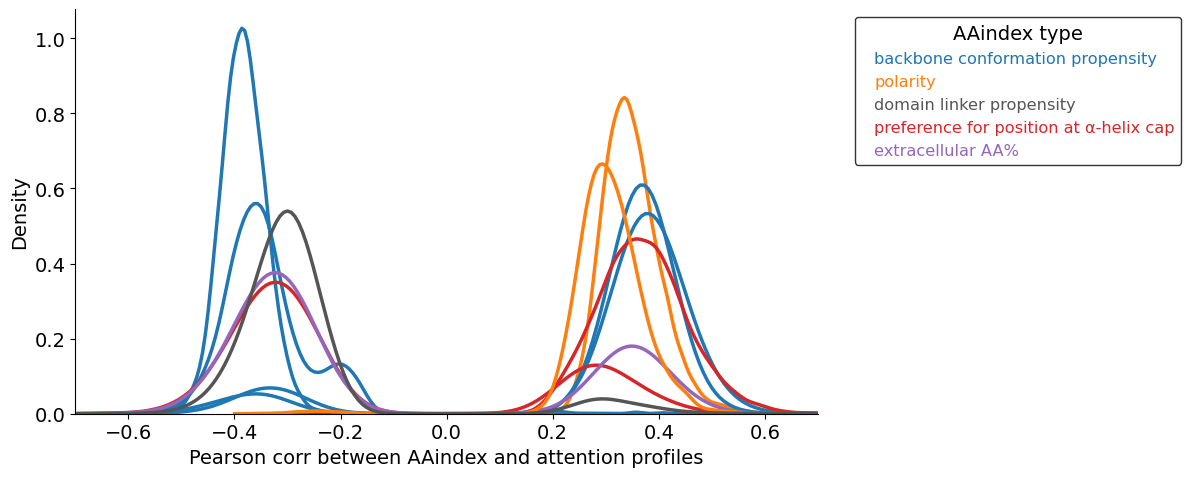

In [16]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 14

splot = sns.displot(hi_corr_vals, 
                    x = 'value', hue='AAindex', kind = 'kde',
                    palette = sns.color_palette(plot_type_colors),
                    aspect = 1.7, linewidth = 2.5,
                    legend=False)
plt.xlim(-0.7, 0.7)
plt.xlabel('Pearson corr between AAindex and attention profiles')

plt.legend(title='AAindex type', loc='upper right', bbox_to_anchor = (1.5, 1),
           fontsize='small', edgecolor='black',
           labels=aaidx_colors.keys(),
           labelcolor=aaidx_colors.values(),
           handlelength=0)

splot.savefig('aaindex_corr.pdf', dpi=100)

In [ ]:
hi_corr_vals.to_csv('aaindex_hi_corr_vals.csv', index=False)

In [ ]:
plt.figure(dpi=100, figsize=(6, 4))
           
g = sns.histplot(
    data = pvals.query('AAindex in @hi_att_corr_aa_indices'),
    bins = 100,
    x = 'p-value',
    hue = 'AAindex'
)

sns.move_legend(g, 'upper right', ncol=2, fontsize=10)
plt.yscale('log')

## Separate pos / neg correlates

In [ ]:
seq_data_and_corr = pd.merge(
    hi_corr_vals.assign(
        corr_sense = hi_corr_vals['value'].map(lambda v: 'pos' if v > 0 else 'neg')
    ).rename(columns={'value': 'corr'}),
    seq_and_abundances[['swissprot_ac', 'Median_molecules_per_cell']],
    
    on = 'swissprot_ac'
)

seq_data_and_corr = seq_data_and_corr.assign(
    log_Median_molecules_per_cell = np.log(seq_data_and_corr['Median_molecules_per_cell'])
)

seq_data_and_corr.head(4)

In [ ]:
seq_data_and_corr.query('corr_sense == "pos"').query('AAindex == "NAKH920107"')['corr'].mean()

In [ ]:
seq_data_and_corr.query('corr_sense == "neg"').query('AAindex == "NAKH920107"')['corr'].mean()

In [ ]:
pos_neg_corrs = pd.merge(

    pd.merge(
        seq_data_and_corr.query('corr_sense == "pos"').groupby('AAindex')['corr'].mean().reset_index(),
        seq_data_and_corr.query('corr_sense == "pos"').groupby('AAindex')['corr'].count().rename('count').reset_index()
    ),

    pd.merge(
        seq_data_and_corr.query('corr_sense == "neg"').groupby('AAindex')['corr'].mean().reset_index(),
        seq_data_and_corr.query('corr_sense == "neg"').groupby('AAindex')['corr'].count().rename('count').reset_index()
    ),

    on = 'AAindex', suffixes=('_pos', '_neg')
)

# .merge(
#     seq_data_and_corr[['AAindex', 'desc']].drop_duplicates()
# )


pos_neg_corrs = pos_neg_corrs.assign(
    index_type = pos_neg_corrs['AAindex'].map(id_type_mapping.get)
)

pos_neg_corrs.sort_values('corr_pos', ascending=False)

In [ ]:
g = sns.FacetGrid(data = seq_data_and_corr, hue='corr_sense', col = 'AAindex', 
                  col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'log_Median_molecules_per_cell')

plt.tight_layout()

## Closer look at transmembrane AAindex

In [ ]:
transmembrane_proteins = set(pd.read_csv('../../data/transmembrane_proteins_yeast.tsv', sep='\t')['Entry'].values)

hi_corr_vals = hi_corr_vals.assign(transmembrane = hi_corr_vals['swissprot_ac'].isin(transmembrane_proteins))

In [ ]:
sns.displot(data = hi_corr_vals.query('(AAindex == "NAKH920107") & (value < -0.3)'),
            x = 'value', hue = 'transmembrane',
            kind='kde')
plt.xlabel('Pearson corr with extracellular AA%')

## Compare costs of successful mutants  (20% regime)

In [ ]:
mut_res = pd.read_csv('informed_mutation/guided_mutation_results.csv.gz')
mut_res = mut_res.rename(columns = {'name': 'scheme'})
mut_ret = mut_res.query('scheme == "percent_20"')

In [ ]:
signif_aa_indices = hi_corr_vals['AAindex'].unique().tolist()

In [ ]:
from aaindex.aaindex import aaindex


def mean_seq_aaindex(seq: str, protein_id: str, partition_label: str):
    """Return mean AAindex for the protein seq"""    
    value_for_protein = {}
    for aa_idx in signif_aa_indices:
        value_for_protein[aa_idx] = list(map(lambda aa: aaindex[aa_idx]['values'][aa], seq))
        value_for_protein[aa_idx] = np.array(value_for_protein[aa_idx]).mean()

    value_for_protein = pd.DataFrame.from_records(list(value_for_protein.items()),
                                                  columns=['AAindex', 'mean_value'])
    value_for_protein = value_for_protein.assign(swissprot_ac = protein_id)
    return value_for_protein[['swissprot_ac', 'AAindex', 'mean_value']].assign(partition = partition_label)


mutant_protein_aaindex = pd.concat(
    (
        mut_ret.progress_apply(
            lambda row: mean_seq_aaindex(row['seq_wt'], row['swissprot_ac'], partition_label = 'wt'),
            axis='columns'
        ).values.tolist()
        +
        mut_ret.progress_apply(
            lambda row: mean_seq_aaindex(row['seq_mut'], row['swissprot_ac'], partition_label = 'mutant'),
            axis='columns'
        ).values.tolist()
        +
        mut_ret.progress_apply(
            lambda row: mean_seq_aaindex(row['seq_mut_control'], row['swissprot_ac'], partition_label = 'rand_ctrl'),
            axis='columns'
        ).values.tolist()
    ),
    ignore_index = True
)

In [ ]:
def mean_aaindex_delta(grp_df) -> float:
    mean_aaindex = dict(grp_df[['partition', 'mean_value']].values)
    return pd.DataFrame.from_records(
        [(100 * (mean_aaindex['mutant'] - mean_aaindex['wt']) / mean_aaindex['wt'], 'mutant'),
         (100 * (mean_aaindex['rand_ctrl'] - mean_aaindex['wt']) / mean_aaindex['wt'], 'rand_ctrl')],
        columns = ['delta_percent', 'partition']
    )


aaindex_deltas = (
    mutant_protein_aaindex
    .groupby(['swissprot_ac', 'AAindex'])
    .progress_apply(mean_aaindex_delta)
    .reset_index().drop(columns='level_2')
)

In [ ]:
plt.figure(dpi=100, figsize=(10, 6))

g = sns.FacetGrid(aaindex_deltas, 
                  hue = 'partition', col='AAindex', 
                  palette = {'mutant': 'black', 'rand_ctrl': 'red'},
                  col_wrap = 4, legend_out=True,
                  sharex=False, sharey=False )

g.map_dataframe(sns.kdeplot, x='delta_percent')

g.set_axis_labels('Mean AAindex difference %', 'density')
_ = g.fig.subplots_adjust(top=0.9) 
_ = g.fig.suptitle('Mean AAindex change %')

In [ ]:
def assess_delta_significance(grp_df):
    mut_delta = grp_df.query('partition == "mutant"')['delta_percent'].values
    ctrl_delta = grp_df.query('partition == "rand_ctrl"')['delta_percent'].values
    return stats.ttest_rel(mut_delta, ctrl_delta)[1]


aaindex_deltas.groupby('AAindex').apply(assess_delta_significance)

In [ ]:
short_descr = {
    'backbone conformation propensity': 'backbone conformation',
    'polarity': 'polarity',
    'domain linker propensity': 'domain linker',
    'preference for position at α-helix cap': 'position at α-helix cap',
    'extracellular AA%': 'extracellular AA%'
}

In [ ]:
id_type_mapping

In [ ]:
aaidx_colors_short = {
    'backbone conformation': 'black',
    'polarity': '#40B0A6',
    'domain linker': 'darkorange',
    'position at α-helix cap': 'blue',
    'extracellular AA%': 'red'
}

In [ ]:
plt.figure(dpi=100, figsize=(6, 4))

mean_aaindex_deltas = aaindex_deltas.groupby(['AAindex', 'partition'])['delta_percent'].mean().reset_index()
idx_labels = mean_aaindex_deltas.query('partition == "mutant"').sort_values('delta_percent')['AAindex'].values

g = sns.barplot(
    data = aaindex_deltas,
    x = 'AAindex', y = 'delta_percent',
    hue = 'partition',
    order = idx_labels,
    palette = {'mutant': 'black', 'rand_ctrl': 'red'},
)
sns.move_legend(g, 'lower right')


g.set_xticklabels([short_descr[id_type_mapping[idx]] for idx in idx_labels])
for label_obj in g.get_xticklabels():
    label_obj.set_color(aaidx_colors_short[label_obj.get_text()])

plt.xticks(rotation=30, ha='right')

plt.xlabel('AAindex')
plt.ylabel('Mean AAindex difference %')

plt.savefig('mean_aaindex_diff_mutants.pdf')

In [ ]:
aaindex_deltas.to_csv('aaindex_deltas.csv', index=False)

In [ ]:
aaindex_deltas.query('partition == "mutant"').groupby('AAindex').mean().sort_values('delta_percent')

In [ ]:
mean_cost_changes = (
    aaindex_deltas
    .groupby(['AAindex', 'partition']).mean()
    .reset_index()
    .sort_values(['partition', 'delta_percent'])
)

pd.merge(
    mean_cost_changes.query('partition == "mutant"'),
    mean_cost_changes.query('partition == "rand_ctrl"'),
    on = 'AAindex',
    suffixes = ('_mutant', '_control')
).drop(columns = ['partition_mutant', 'partition_control'])

In [ ]:
plt.figure(dpi=100, figsize=(6, 4))

mean_aaindex_deltas = aaindex_deltas.groupby(['AAindex', 'partition'])['delta_percent'].mean().reset_index()
idx_labels = mean_aaindex_deltas.query('partition == "mutant"').sort_values('delta_percent')['AAindex'].values

g = sns.barplot(
    data = aaindex_deltas,
    x = 'AAindex', y = 'delta_percent',
    hue = 'partition',
    order = idx_labels,
    palette = {'mutant': 'black', 'rand_ctrl': 'red'},
)
sns.move_legend(g, 'lower right')

plt.xticks(rotation=30, ha='right')

plt.xlabel('AAindex')
plt.ylabel('Mean AAindex difference %')